# Benchmarking Acquisition Functions

The choice of acquisition function for a Bayesian optimization campaign is an important decision that can greatly affect the efficiency with which an optimal solution is found. While expected improvement is often a good starting choice, it isn't always the most effective acquisition function. For example, upper confidence bound is known to outperform expected improvement in multimodal problems where exploration is essential to finding the global optima. However, knowing which acquisition function to choose for a given problem isn't always straightforward, especially for complicated design spaces.

One approach is to simulate optimization campaigns with different acquisition functions on synthetic problems. By directly controlling the parameters of the problem, practitioners can benchmark different optimization setups ahead of a real experimental campaign. This can then guide practitioners towards better optimization strategies - provided the synthetic optimization problem is sufficienty similar to the problem of interest. Fortunately, there are a wide variety of synthetic functions available within the [Ax library](https://ax.dev/api/metrics.html) and [online](https://www.sfu.ca/~ssurjano/optimization.html) that can be used.

---

Your team is planning to use Bayesian optimziation to desing formulations for dental composites. Your boss has asked you to recommend an effective acquisition function for them to use. She heard that probability of improvement has worked well in the past but is curious how it compares with upper confidence bound. To assess their relative performance, you decide to benchmark each acquisition function on the Hartmann6 objective function. As the real experimental budget is limited you decide to optimize over 15 total trials with only 4 sobol trials. Additionally, due to some concerns over the impact of initialization, you decide to test each aquisition function across five random seeds.

You believe Honegumi can help you construct a simple optimization script to perform this benchmarking task.

To simulate this task, the Hartmann6 metric from the Ax library will be wrapped in a function. Although optimal values for this function are known, we will pretend that such information is unknown and rely on Bayesian optimization to find the optimal parameters instead.

In [1]:
from ax.utils.measurement.synthetic_functions import hartmann6

def HART(x):
    """Wrapper for the Hartmann6 function, used for demonstration purposes."""
    return {"hartmann6": (hartmann6(x), 0.0)}

## Applying Honegumi

We will now use the [Honegumi](https://honegumi.readthedocs.io/en/latest/index.html) website to generate a script that will help us benchmark different acquisition functions. Unlike other tutorials, however, this will require more extensive modifications to the generated script in order to facilitate testing different random seeds and acquisition functions. From the description, we observe that our problem is a simple **single objective** optimization problem that we are interested in applying a **custom model** to.

![Honegumi Selections for Benchmarking Optimization](benchmarking_selection.png)

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# MOD:` has been added along with a brief description of the change.

.. note::

    [NOTE] This code will take approximately a minute to run.

In [ ]:
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties

from ax.modelbridge.factory import Models
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy

# MOD: also import probability of improvement
from botorch.acquisition import ProbabilityOfImprovement, UpperConfidenceBound

obj1_name = "hartmann6" # MOD: update objective name

# MOD: remove the branin dummy objective function, we will use tabulated data

n_seeds = 3 # MOD: set number of seeds to loop over

# MOD: make a dictionary to store optimization traces
traces = {
    "ProbabilityOfImprovement": np.zeros((n_seeds, 15)),
    "UpperConfidenceBound": np.zeros((n_seeds, 15)),
}

for acqf in [ProbabilityOfImprovement, UpperConfidenceBound]: # MOD: loop over acqf
    for seed in range(n_seeds): # MOD: loop over seeds

        gs = GenerationStrategy(
            steps=[
                GenerationStep(
                    model=Models.SOBOL,
                    num_trials=4,
                    min_trials_observed=3,
                    max_parallelism=5,
                    model_kwargs={"seed": seed}, # MOD: used loop seed
                    model_gen_kwargs={},
                ),
                GenerationStep(
                    model=Models.BOTORCH_MODULAR, # MOD: use modular botorch model
                    num_trials=-1,
                    max_parallelism=3,
                    model_kwargs={"botorch_acqf_class": acqf}, # MOD: set acqf
                ),
            ]
        )

        ax_client = AxClient(generation_strategy=gs,
                             verbose_logging=False, # MOD: reduce logged information
                             random_seed=seed) # MOD: use loop seed

        ax_client.create_experiment(
            parameters=[
                {"name": "x1", "type": "range", "bounds": [0.0, 1.0]}, # MOD: update
                {"name": "x2", "type": "range", "bounds": [0.0, 1.0]}, # MOD: update
                {"name": "x3", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add
                {"name": "x4", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add
                {"name": "x5", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add
                {"name": "x6", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add
            ],
            objectives={
                obj1_name: ObjectiveProperties(minimize=True),
            },
        )

        for _ in range(15): # MOD: set num trials to 15
            parameterization, trial_index = ax_client.get_next_trial()

            # MOD: pull parameters from parameterization
            x1 = parameterization["x1"]
            x2 = parameterization["x2"]
            x3 = parameterization["x3"]
            x4 = parameterization["x4"]
            x5 = parameterization["x5"]
            x6 = parameterization["x6"]

            results = HART(np.array([x1, x2, x3, x4, x5, x6])) # MOD: use HART function
            ax_client.complete_trial(trial_index=trial_index, raw_data=results)

        name = acqf.__name__ # MOD: get name of current acquisition function

        traces[name][seed,:] = ax_client.get_trace() # MOD: store the optimization trace

.. note::

    [NOTE] The output of the above cell has been hidden in the interest of clarity.

## Plotting Optimization Performance
To assess the performance of each acquisition function we plot the average and standard deviation of the optimization traces over each seed. The included visualization tools do not account for benchmarking, so we will need to write some custom plotting code for this.

We observe that upper confidence bound performs significantly better than probability of improvement and is likely the better choice for our actual experimental trials. The standard deviations on both are quite wide, but this may be an effect of the limited number of seeds tested - a proper benchmark should consider 25+ seeds.

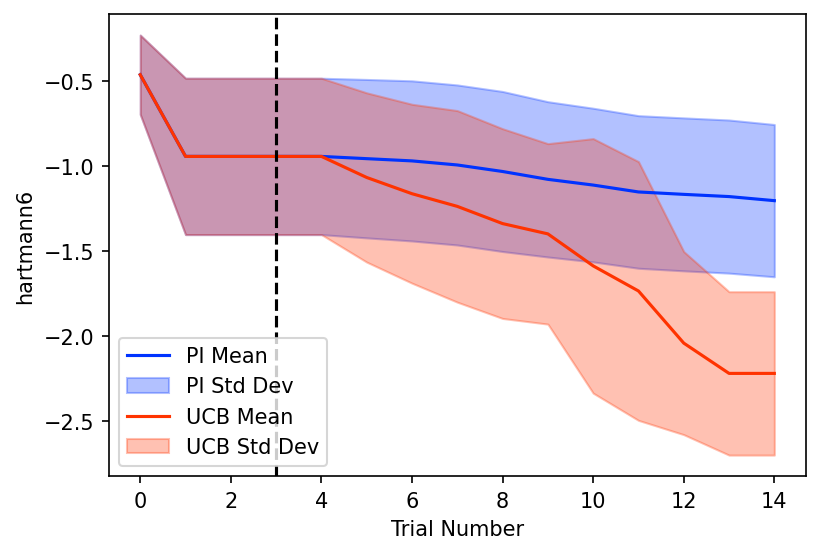

In [4]:
import matplotlib.pyplot as plt

objectives = ax_client.objective_names

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

for acqf, name in zip(traces.keys(), ["PI", "UCB"]):

    mean = np.mean(traces[acqf], axis=0)
    std = np.std(traces[acqf], axis=0)

    color = '#0033FF' if name == "PI" else '#FF3300'

    ax.plot(mean, color=color, label=f"{name} Mean")
    ax.fill_between(
        range(len(mean)), mean - std, mean + std,
        color=color, alpha=0.3, label=f"{name} Std Dev"
    )

ax.axvline(3, color='black', linestyle='--') # mark end of SOBOL trials

ax.set_xlabel("Trial Number")
ax.set_ylabel(objectives[0])
ax.legend()
plt.show()

## Next Steps

Interested in taking this further? Try to implement the following on your own!

1. Add the `ExpectedImprovement` and `LogExpectedImprovement` acquisition functions to the script and see how they compare.

2. Increase or decrease the number of sobol trials to assess the effects of initialization count on relative performance.

3. Extend the total number of trials and determine how many iterations it takes for all acquisition functions to converge to the true optimal objective function value.